<a href="https://colab.research.google.com/github/Rosvend/Passenger-flow-prediction-LSTM/blob/main/LSTM_Metro_passenger_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM (Long short-term memory) para la predicción a corto plazo del flujo de pasajeros en la red metro de Medellín, Antioquia.**

Este proyecto busca predecir el flujo de pasajeros en la red Metro de Medellín, Antioquia. Para esto se utilizan herramientas como Tensorflow y Keras para construir un modelo LSTM, buscando patrones clave para la detección de características de comportamientos que permitan mejorar el rendimiento y operacionalidad de las redes Metro, además de brindar ideas relevantes para la resolución de problemas.

# Importando librerías

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from ipywidgets import interact, interact_manual, Dropdown

In [89]:
!pip install holidays_co

In [90]:
from holidays_co import get_colombia_holidays_by_year
holidays = get_colombia_holidays_by_year(2023)
print(holidays)

[Holiday(date=datetime.date(2023, 1, 1), celebration='Año Nuevo'), Holiday(date=datetime.date(2023, 1, 9), celebration='Día de los Reyes Magos'), Holiday(date=datetime.date(2023, 3, 20), celebration='Día de San José'), Holiday(date=datetime.date(2023, 4, 6), celebration='Jueves Santo'), Holiday(date=datetime.date(2023, 4, 7), celebration='Viernes Santo'), Holiday(date=datetime.date(2023, 5, 1), celebration='Día del Trabajo'), Holiday(date=datetime.date(2023, 5, 22), celebration='Ascensión del Señor'), Holiday(date=datetime.date(2023, 6, 12), celebration='Corphus Christi'), Holiday(date=datetime.date(2023, 6, 19), celebration='Sagrado Corazón de Jesús'), Holiday(date=datetime.date(2023, 7, 3), celebration='San Pedro y San Pablo'), Holiday(date=datetime.date(2023, 7, 20), celebration='Día de la Independencia'), Holiday(date=datetime.date(2023, 8, 7), celebration='Batalla de Boyacá'), Holiday(date=datetime.date(2023, 8, 21), celebration='La Asunción de la Virgen'), Holiday(date=datetime.d

In [91]:
from holidays_co import is_holiday_date
import datetime

date = datetime.date(2024,5,13) #Lunes festivo 13 de mayo 2024 como ejemplo (Dia de la Ascencion)

print(date)
is_holiday_date(date)

2024-05-13


True

#Cargando datos


In [92]:
print('Descargando archivos...')
!curl -L "https://drive.google.com/uc?id=1Vk3kISIRnWhpF55VAlsXiaBC7-2VS7mp&export=download" -o Afluencia2024.xlsx
!curl -L "https://drive.google.com/uc?id=1rawKGyqGLCjhYsE1oePv499lQdawN3zX&export=download" -o Afluencia2023.xlsx
!curl -L "https://drive.google.com/uc?id=11VeQzlInoljZKKil7kPcWjwvESCZbMSv&export=download" -o Afluencia2022.xlsx
!curl -L "https://drive.google.com/uc?id=1zWP6FHA6aTJJ58xy119k5tAQRxI3DEIF&export=download" -o Afluencia2021.xlsx
!curl -L "https://drive.google.com/uc?id=1klQ3qzRFX2-jpkc4Nh8wLIo6weFKQ6Pa&export=download" -o Afluencia2020.xlsx
!curl -L "https://drive.google.com/uc?id=1PsQvhT1bt6-xr5vG1Xi95aHBg2anYI51&export=download" -o Afluencia2019.xlsx

Descargando archivos...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60500  100 60500    0     0  83334      0 --:--:-- --:--:-- --:--:--  141k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  659k  100  659k    0     0   465k      0  0:00:01  0:00:01 --:--:-- 5235k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  648k  100  648k    0     0   369k      0  0:00:01  0:00:01 --:--:-- 1407k
  % Total    % Received % Xf

In [93]:
df2019 = pd.read_excel('/content/Afluencia2019.xlsx',engine='openpyxl')
df2020 = pd.read_excel('/content/Afluencia2020.xlsx',engine='openpyxl')
df2021 = pd.read_excel('/content/Afluencia2021.xlsx',engine='openpyxl')
df2022 = pd.read_excel('/content/Afluencia2022.xlsx',engine='openpyxl')
df2023 = pd.read_excel('/content/Afluencia2023.xlsx',engine='openpyxl')
df2024 = pd.read_excel('/content/Afluencia2024.xlsx',engine='openpyxl')
df2023.head(13) #Imprimos las 12 lineas del metro

,Día,Línea de Servicio,Hora de operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106
5,01/01/2023,LÍNEA H,NaN,NaN,NaN,NaN,NaN,56,62,49,...,55,128,99,109,68,46,27,1,NaN,970
6,01/01/2023,LÍNEA J,NaN,NaN,NaN,NaN,NaN,470,410,490,...,688,710,857,933,651,311,146,3,NaN,7209
7,01/01/2023,LÍNEA K,NaN,NaN,NaN,NaN,350,555,630,745,...,1432,1515,1788,1562,1110,766,329,4,NaN,13664
8,01/01/2023,LÍNEA L,NaN,NaN,NaN,NaN,11,61,158,364,...,617,531,428,NaN,NaN,NaN,NaN,NaN,NaN,4113
9,01/01/2023,LÍNEA M,NaN,NaN,NaN,NaN,1,156,123,176,...,229,332,319,411,408,260,240,92,NaN,3425


# Proceso de calidad de datos

In [94]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3564 non-null   object
 1   Unnamed: 1   3564 non-null   object
 2   Unnamed: 2   2937 non-null   object
 3   Unnamed: 3   2958 non-null   object
 4   Unnamed: 4   2960 non-null   object
 5   Unnamed: 5   2989 non-null   object
 6   Unnamed: 6   3426 non-null   object
 7   Unnamed: 7   3501 non-null   object
 8   Unnamed: 8   3499 non-null   object
 9   Unnamed: 9   3517 non-null   object
 10  Unnamed: 10  3513 non-null   object
 11  Unnamed: 11  3515 non-null   object
 12  Unnamed: 12  3524 non-null   object
 13  Unnamed: 13  3517 non-null   object
 14  Unnamed: 14  3525 non-null   object
 15  Unnamed: 15  3536 non-null   object
 16  Unnamed: 16  3361 non-null   object
 17  Unnamed: 17  3226 non-null   object
 18  Unnamed: 18  3230 non-null   object
 19  Unnamed: 19  3228 non-null 

In [95]:
df2019.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
2,2019-01-01 00:00:00,Línea 1,12,826,1134,987,884,975,1259,1348,...,2085,2230,2636,2884,2603,2024,1257,271,5,28850
3,2019-01-02 00:00:00,Línea 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4709,5750,7517,6661,4307,2975,2709,1890,135,83484
4,2019-01-03 00:00:00,Línea 1,1860,4869,7587,7088,4483,4486,4126,4136,...,5061,6093,8023,7034,4481,3244,2905,1739,124,90472


In [96]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2019 = df2019.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2019.columns.to_list()

['Unnamed: 0',
 'Unnamed: 1',
 '4AM',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [97]:
df2019 = df2019.rename(columns={'Unnamed: 0':'Dia','Unnamed: 1':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2019 = df2019.drop([0,1])
df2019.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2019-01-01 00:00:00,Línea 1,12,826,1134,987,884,975,1259,1348,...,2085,2230,2636,2884,2603,2024,1257,271,5,28850
3,2019-01-02 00:00:00,Línea 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4709,5750,7517,6661,4307,2975,2709,1890,135,83484
4,2019-01-03 00:00:00,Línea 1,1860,4869,7587,7088,4483,4486,4126,4136,...,5061,6093,8023,7034,4481,3244,2905,1739,124,90472
5,2019-01-04 00:00:00,Línea 1,1845,4989,7723,7281,4857,4583,4269,4217,...,5280,6056,7992,7081,4805,3466,3075,1900,176,93067
6,2019-01-05 00:00:00,Línea 1,1550,3852,4898,5221,4016,3815,3704,4048,...,4696,4528,4106,4377,3842,2973,2866,1983,167,75451


In [98]:
df2020.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
2,2020-01-01 00:00:00,Línea 1,NaN,902,1126,881,743,924,1137,1299,...,2056,2374,2727,2908,2978,2457,1369,174,NaN,29341
3,2020-01-01 00:00:00,Línea 2,NaN,63,94,66,68,61,79,127,...,169,188,287,302,236,188,85,16,NaN,2435
4,2020-01-01 00:00:00,Línea A,1,4901,6168,4822,4158,5152,6467,8488,...,12785,15911,19522,20582,20358,16450,10701,1177,NaN,192714


In [99]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2020 = df2020.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2020.columns.to_list()

['Unnamed: 0',
 'Unnamed: 1',
 '4AM',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [100]:
df2020 = df2020.rename(columns={'Unnamed: 0':'Dia','Unnamed: 1':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2020 = df2020.drop([0,1])
df2020.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2020-01-01 00:00:00,Línea 1,NaN,902,1126,881,743,924,1137,1299,...,2056,2374,2727,2908,2978,2457,1369,174,NaN,29341
3,2020-01-01 00:00:00,Línea 2,NaN,63,94,66,68,61,79,127,...,169,188,287,302,236,188,85,16,NaN,2435
4,2020-01-01 00:00:00,Línea A,1,4901,6168,4822,4158,5152,6467,8488,...,12785,15911,19522,20582,20358,16450,10701,1177,NaN,192714
5,2020-01-01 00:00:00,Línea B,NaN,750,863,674,693,891,1161,1600,...,2140,2775,2942,3083,2319,1738,725,39,NaN,28691
6,2020-01-01 00:00:00,Línea H,NaN,NaN,NaN,NaN,1,39,60,65,...,66,130,105,136,121,49,14,2,NaN,1030


In [101]:
df2021.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
2,2021-01-01 00:00:00,LÍNEA A,NaN,3487,3405,2011,1148,974,888,1011,...,1833,2900,3269,3314,2273,1329,12,NaN,NaN,31911
3,2021-01-01 00:00:00,LÍNEA B,NaN,532,438,267,164,145,135,142,...,212,321,421,432,215,157,NaN,NaN,NaN,4050
4,2021-01-01 00:00:00,LÍNEA K,NaN,NaN,NaN,NaN,40,131,104,156,...,167,258,189,122,103,38,NaN,NaN,NaN,1714


In [102]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2021 = df2021.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2021.columns.to_list()

['Unnamed: 0',
 'Unnamed: 1',
 '4AM',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [103]:
df2021 = df2021.rename(columns={'Unnamed: 0':'Dia','Unnamed: 1':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2021 = df2021.drop([0,1])
df2021.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2021-01-01 00:00:00,LÍNEA A,NaN,3487,3405,2011,1148,974,888,1011,...,1833,2900,3269,3314,2273,1329,12,NaN,NaN,31911
3,2021-01-01 00:00:00,LÍNEA B,NaN,532,438,267,164,145,135,142,...,212,321,421,432,215,157,NaN,NaN,NaN,4050
4,2021-01-01 00:00:00,LÍNEA K,NaN,NaN,NaN,NaN,40,131,104,156,...,167,258,189,122,103,38,NaN,NaN,NaN,1714
5,2021-01-01 00:00:00,LÍNEA J,NaN,NaN,NaN,NaN,1,77,74,92,...,146,179,132,135,69,42,3,NaN,NaN,1256
6,2021-01-01 00:00:00,LÍNEA 1,NaN,614,590,355,240,217,198,231,...,394,579,624,574,399,231,17,NaN,NaN,6104


In [104]:
df2021['Dia'] = pd.to_datetime(df2021['Dia'], format='%d/%m/%Y', errors='coerce')
df2021.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2021-01-01,LÍNEA A,NaN,3487,3405,2011,1148,974,888,1011,...,1833,2900,3269,3314,2273,1329,12,NaN,NaN,31911
3,2021-01-01,LÍNEA B,NaN,532,438,267,164,145,135,142,...,212,321,421,432,215,157,NaN,NaN,NaN,4050
4,2021-01-01,LÍNEA K,NaN,NaN,NaN,NaN,40,131,104,156,...,167,258,189,122,103,38,NaN,NaN,NaN,1714
5,2021-01-01,LÍNEA J,NaN,NaN,NaN,NaN,1,77,74,92,...,146,179,132,135,69,42,3,NaN,NaN,1256
6,2021-01-01,LÍNEA 1,NaN,614,590,355,240,217,198,231,...,394,579,624,574,399,231,17,NaN,NaN,6104


In [105]:
df2022.head()

,Día,Línea de Servicio,Hora de operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaT,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,2022-01-01,LÍNEA 1,165,811,854,662,589,731,836,1091,...,1479,1616,1696,1911,1611,1319,923,132,NaN,20279
2,2022-01-01,LÍNEA 2,14,90,100,81,68,95,93,90,...,168,212,213,222,169,118,71,8,NaN,2265
3,2022-01-01,LÍNEA A,1098,4363,5114,3988,3385,4033,4890,6163,...,9089,10642,11322,12716,10610,8085,6333,476,NaN,126692
4,2022-01-01,LÍNEA B,195,674,767,555,565,667,921,1246,...,1599,2121,2114,2204,1526,1028,620,58,NaN,21301


In [106]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2022 = df2022.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2022.columns.to_list()

['Día',
 'Línea de Servicio',
 'Hora de operación',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [107]:
df2022 = df2022.rename(columns={'Día':'Dia','Línea de Servicio':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2022 = df2022.drop([0])
df2022.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
1,2022-01-01,LÍNEA 1,165,811,854,662,589,731,836,1091,...,1479,1616,1696,1911,1611,1319,923,132,NaN,20279
2,2022-01-01,LÍNEA 2,14,90,100,81,68,95,93,90,...,168,212,213,222,169,118,71,8,NaN,2265
3,2022-01-01,LÍNEA A,1098,4363,5114,3988,3385,4033,4890,6163,...,9089,10642,11322,12716,10610,8085,6333,476,NaN,126692
4,2022-01-01,LÍNEA B,195,674,767,555,565,667,921,1246,...,1599,2121,2114,2204,1526,1028,620,58,NaN,21301
5,2022-01-01,LÍNEA H,NaN,NaN,NaN,NaN,NaN,39,25,45,...,44,37,71,80,61,42,14,NaN,NaN,641


In [108]:
df2023.head()

,Día,Línea de Servicio,Hora de operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106


In [109]:
#Cambiamos los nombres de las columnas de horas
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2023 = df2023.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2023.columns.to_list()

['Día',
 'Línea de Servicio',
 'Hora de operación',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [110]:
df2023 = df2023.rename(columns={'Día':'Dia','Línea de Servicio':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2023 = df2023.drop([0]) #Borramos la primera fila
df2023.head(12)

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106
5,01/01/2023,LÍNEA H,NaN,NaN,NaN,NaN,NaN,56,62,49,...,55,128,99,109,68,46,27,1,NaN,970
6,01/01/2023,LÍNEA J,NaN,NaN,NaN,NaN,NaN,470,410,490,...,688,710,857,933,651,311,146,3,NaN,7209
7,01/01/2023,LÍNEA K,NaN,NaN,NaN,NaN,350,555,630,745,...,1432,1515,1788,1562,1110,766,329,4,NaN,13664
8,01/01/2023,LÍNEA L,NaN,NaN,NaN,NaN,11,61,158,364,...,617,531,428,NaN,NaN,NaN,NaN,NaN,NaN,4113
9,01/01/2023,LÍNEA M,NaN,NaN,NaN,NaN,1,156,123,176,...,229,332,319,411,408,260,240,92,NaN,3425
10,01/01/2023,LÍNEA O,10,122,172,99,107,138,95,150,...,216,234,272,326,222,198,109,14,NaN,2944


In [111]:
df2024.head()

,Día,Línea de Servicio,Hora de Operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaT,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,2024-01-01,LÍNEA 1,203,894,964,773,709,901,1014,1133,...,1629,1793,2173,2439,1983,1737,1165,165,3,23946
2,2024-01-01,LÍNEA 2,5,158,152,83,109,143,132,249,...,202,292,312,301,221,161,107,16,NaN,3242
3,2024-01-01,LÍNEA A,1553,5705,5948,4926,4161,4673,5692,7401,...,10887,13231,15615,17187,14787,11986,7907,749,NaN,161634
4,2024-01-01,LÍNEA B,258,742,870,710,674,848,1092,1451,...,2014,2291,2653,2792,2081,1347,927,94,NaN,26116


In [112]:
#Cambiamos los nombres de las columnas de horas
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2024 = df2024.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2024.columns.to_list()

['Día',
 'Línea de Servicio',
 'Hora de Operación',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [113]:
df2024 = df2024.rename(columns={'Día':'Dia','Línea de Servicio':'Linea','Hora de Operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2024 = df2024.drop([0])
df2024.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
1,2024-01-01,LÍNEA 1,203,894,964,773,709,901,1014,1133,...,1629,1793,2173,2439,1983,1737,1165,165,3,23946
2,2024-01-01,LÍNEA 2,5,158,152,83,109,143,132,249,...,202,292,312,301,221,161,107,16,NaN,3242
3,2024-01-01,LÍNEA A,1553,5705,5948,4926,4161,4673,5692,7401,...,10887,13231,15615,17187,14787,11986,7907,749,NaN,161634
4,2024-01-01,LÍNEA B,258,742,870,710,674,848,1092,1451,...,2014,2291,2653,2792,2081,1347,927,94,NaN,26116
5,2024-01-01,LÍNEA H,NaN,NaN,NaN,NaN,2,59,67,84,...,78,101,85,121,83,43,29,7,NaN,990


In [114]:
dfs = [df2019, df2020, df2021, df2022, df2023, df2024]
for df in dfs:
    if 'Dia' in df.columns:
        df['Dia'] = pd.to_datetime(df['Dia'], format='%d/%m/%Y', errors='coerce')

df = pd.concat(dfs, axis=0,ignore_index=True)
#df.to_excel('Afluencia2020-2024.xlsx',index=False)
df['Linea'] = df['Linea'].str.upper()
df.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
0,2019-01-01,LÍNEA 1,12,826,1134,987,884,975,1259,1348,...,2085,2230,2636,2884,2603,2024,1257,271,5,28850
1,2019-01-02,LÍNEA 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4709,5750,7517,6661,4307,2975,2709,1890,135,83484
2,2019-01-03,LÍNEA 1,1860,4869,7587,7088,4483,4486,4126,4136,...,5061,6093,8023,7034,4481,3244,2905,1739,124,90472
3,2019-01-04,LÍNEA 1,1845,4989,7723,7281,4857,4583,4269,4217,...,5280,6056,7992,7081,4805,3466,3075,1900,176,93067
4,2019-01-05,LÍNEA 1,1550,3852,4898,5221,4016,3815,3704,4048,...,4696,4528,4106,4377,3842,2973,2866,1983,167,75451


In [115]:
df['Festivo'] = df['Dia'].apply(is_holiday_date) #Anadimos una columna para dias festivos
df.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros,Festivo
0,2019-01-01,LÍNEA 1,12,826,1134,987,884,975,1259,1348,...,2230,2636,2884,2603,2024,1257,271,5,28850,True
1,2019-01-02,LÍNEA 1,1716,4498,6629,6284,4145,3784,3746,3854,...,5750,7517,6661,4307,2975,2709,1890,135,83484,False
2,2019-01-03,LÍNEA 1,1860,4869,7587,7088,4483,4486,4126,4136,...,6093,8023,7034,4481,3244,2905,1739,124,90472,False
3,2019-01-04,LÍNEA 1,1845,4989,7723,7281,4857,4583,4269,4217,...,6056,7992,7081,4805,3466,3075,1900,176,93067,False
4,2019-01-05,LÍNEA 1,1550,3852,4898,5221,4016,3815,3704,4048,...,4528,4106,4377,3842,2973,2866,1983,167,75451,False


# Análisis exploratorio de los datos

In [116]:
#Celda interactiva con hora, linea de metro y cantidad minima de pasajeros
@interact
def show_lines(Hora=['4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'],
               Linea=df['Linea'].unique(),
               MinimoPasajeros=(10, 50000, 10)):
    return df.loc[(df[Hora] > MinimoPasajeros) & (df['Linea'] == Linea)]

interactive(children=(Dropdown(description='Hora', options=('4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', …

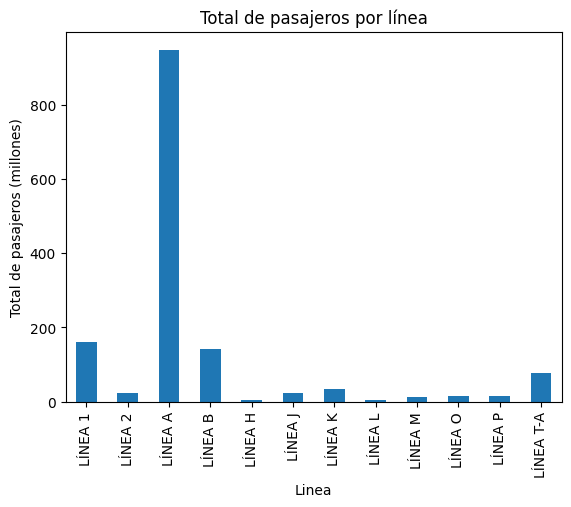

In [117]:
ax = (df.groupby('Linea')['Total_pasajeros'].sum() / 1e6).plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por línea')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [ ]:
ax = (df.drop(columns=['Dia','Linea','Total_pasajeros','Festivo']).sum()/ 1e6).plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por hora')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [ ]:
df_linea_a = df[df['Linea'] == 'LÍNEA A']

passengers_by_hour = (df_linea_a.drop(columns=['Dia', 'Linea', 'Total_pasajeros']).sum() / 1e6)

ax = passengers_by_hour.plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por hora en LÍNEA A')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [ ]:
#grafica interactiva
def update_plot(line):
    df_filtered = df[df['Linea'] == line]
    passengers_by_hour = (df_filtered.drop(columns=['Dia', 'Linea', 'Total_pasajeros','Dia','Festivo','Dia_semana','Tipo de dia','Mes','Year']).sum() / 1e6)
    ax = passengers_by_hour.plot(kind='bar', figsize=(10, 5))
    plt.ylabel('Total de pasajeros (millones)')
    plt.title(f'Total de pasajeros por hora en {line}')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.show()

interact(update_plot, line=Dropdown(options=df['Linea'].unique(), value='LÍNEA A', description='Linea:'))


In [ ]:
df['Dia'] = pd.to_datetime(df['Dia'], format='%d/%m/%Y')

#Nueva columna para el dia de la semana (0=Lunes, 6=Domingo)
df['Dia_semana'] = df['Dia'].dt.dayofweek

# Clasificar como dia de semana o fin de semana
df['Tipo de dia'] = df['Dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Entre semana')

passenger_summary = df.groupby('Tipo de dia')['Total_pasajeros'].mean()


ax = passenger_summary.plot(kind='bar', color=['blue', 'green'])
plt.ylabel('Total de pasajeros')
plt.title('Dias de semana vs Fin de semana')
plt.xticks(rotation=0)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()
#visualizar en cada linea tambien

In [ ]:
df['Dia'] = pd.to_datetime(df['Dia'])

# Extraemos los meses de la columna dia
df['Mes'] = df['Dia'].dt.month

#Flujo de pasajeros por mes
monthly_passenger_flow = df.groupby('Mes')['Total_pasajeros'].sum()/1e6

plt.figure(figsize=(10, 6))
monthly_passenger_flow.plot(kind='bar', color='skyblue')
plt.title('Pasajeros mensuales')
plt.xlabel('Mes')
plt.ylabel('Total de pasajeros (millones)')
plt.xticks(ticks=range(len(monthly_passenger_flow)), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Datos nulos y cambiar tipo de datos

In [ ]:
df.replace('None', np.nan, inplace=True)

In [ ]:
print(df.isna().sum())

In [ ]:
print(df.isnull().sum())

In [ ]:
for col in df.columns[2:22]:
    df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype('int64')
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df['Total_pasajeros'] = pd.to_numeric(df['Total_pasajeros'], errors='coerce')
df['Year'] = df['Dia'].dt.year
df['Year'] = df['Year'].astype('category')
df['Tipo de dia'] = df['Tipo de dia'].astype('category')
df['Dia_semana'] = df['Dia_semana'].astype('category')
df['Mes'] = df['Mes'].astype('category')
df['Linea'] = df['Linea'].astype('category')
print(df.dtypes)

In [ ]:
pasajeros_anuales = df.groupby('Year')['Total_pasajeros'].sum()/1e6

plt.figure(figsize=(10, 6))
pasajeros_anuales.plot(kind='bar', color='skyblue')
plt.title('Pasajeros anuales')
plt.xlabel('Año')
plt.ylabel('Total de pasajeros (millones)')
plt.xticks(ticks=range(len(pasajeros_anuales)), labels=['2019', '2020', '2021', '2022', '2023', '2024'], rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:

def update_plot(year):
    df_filtered = df[df['Year'] == year]

    monthly_passenger_flow = df_filtered.groupby('Mes')['Total_pasajeros'].sum() / 1e6

    ax = monthly_passenger_flow.plot(kind='bar', figsize=(10, 5), title=f'Total de pasajeros por mes en {year}')
    plt.ylabel('Total de pasajeros (millones)')
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.xticks(ticks=range(len(monthly_passenger_flow)), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
    plt.show()

year_options = df['Year'].unique()
default_year = year_options[0] if len(year_options) > 0 else None

interact(update_plot, year=Dropdown(options=year_options, value=default_year, description='Year:'))


In [ ]:
import plotly.express as px

fig = px.scatter(df, x='Dia', y='Total_pasajeros', hover_data=['Dia_semana'])
fig.show()

FALTA VISUALIZARLO EN CADA LÍNEA DEL METRO

In [ ]:
passenger_summary = df.groupby('Festivo')['Total_pasajeros'].mean()

ax = passenger_summary.plot(kind='bar', color=['blue', 'red'], figsize=(8, 5))
plt.ylabel('Promedio de pasajeros')
plt.title('Comparación del flujo promedio de pasajeros: Día festivo vs No festivo')
plt.xticks([0, 1], ['No Festivo', 'Festivo'], rotation=0)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show() #visualizarlo en cada linea tambien

# Detección de outliers y duplicados

In [ ]:
def find_outliers_IQR(df, start_col, end_col):
    columns = df.loc[:, start_col:end_col].columns
    outliers_dict = {}

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3 - q1
        outliers = df[(df[col] < (q1 - 1.5 * IQR)) | (df[col] > (q3 + 1.5 * IQR))]
        outliers_dict[col] = outliers

    return outliers_dict

outliers_dict = find_outliers_IQR(df, '4AM', '11PM')

# Imprimir cantidad de outliers por cada hora
for hour, data in outliers_dict.items():
    print(f'Hora: {hour}, Cantidad de outliers: {len(data)}')

In [ ]:
def find_column_outliers_IQR(df, columns):
    outliers = pd.DataFrame(index=df.index)

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3 - q1
        outliers[col] = (df[col] < (q1 - 1.5 * IQR)) | (df[col] > (q3 + 1.5 * IQR))

    return outliers

hour_columns = df.loc[:, '4AM':'11PM'].columns
column_outliers = find_column_outliers_IQR(df, hour_columns)

# Print number of outliers per column
for col in hour_columns:
    print(f'Column: {col}, Number of outliers: {column_outliers[col].sum()}')

In [ ]:
row_outliers = pd.DataFrame(index=df.index)
for col in hour_columns:
    row_outliers[col] = df.index.isin(outliers_dict[col].index)

combined_outliers = pd.DataFrame(index=df.index)
for col in hour_columns:
    combined_outliers[col] = row_outliers[col] & column_outliers[col]

# Count the number of combined outliers for each hour column
combined_outliers_summary = combined_outliers.sum()
print(combined_outliers_summary)


In [ ]:
# Identify rows with any common outliers
common_outliers = combined_outliers.any(axis=1)

# Extract and display rows that are common outliers
common_outliers_df = df[common_outliers]
common_outliers_df.sample(10)

# Detección de anomalías

In [ ]:
from sklearn.ensemble import IsolationForest
import warnings

# Suppress the UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

hour_columns = df.loc[:, '4AM':'11PM'].columns
column_anomalies = pd.DataFrame(index=df.index)

# Fit Isolation Forest for each hour column
for col in hour_columns:
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(df[[col]])
    column_anomalies[col] = model.predict(df[[col]]) == -1

# Print number of anomalies per column
for col in hour_columns:
    print(f'Column: {col}, Number of anomalies: {column_anomalies[col].sum()}')

In [ ]:
def plot_outliers_boxplots(df, start_col, end_col):
    columns = df.loc[:, start_col:end_col].columns
    num_columns = len(columns)
    fig, axs = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, num_columns*2), constrained_layout=True)

    for i, col in enumerate(columns):
        axs[i].boxplot(df[col].dropna(), vert=False, flierprops=dict(marker='o', color='red', alpha=0.5))
        axs[i].set_title(f'Boxplot for {col}')
        axs[i].set_xlabel('Passenger Count')

    plt.show()

plot_outliers_boxplots(df, '4AM', '11PM')

In [ ]:
# Analyze the correlation of outliers with holidays and weekends
for hour, outliers in outliers_dict.items():
    total_outliers = len(outliers)
    holiday_outliers = outliers['Festivo'].sum()
    weekend_outliers = outliers[outliers['Tipo de dia'] == 'Weekend'].shape[0]
    print(f'Hora: {hour}')
    print(f'  Total outliers: {total_outliers}')
    print(f'  Outliers on holidays: {holiday_outliers} ({holiday_outliers / total_outliers * 100:.2f}%)')
    print(f'  Outliers on weekends: {weekend_outliers} ({weekend_outliers / total_outliers * 100:.2f}%)\n')

In [ ]:
from sklearn.ensemble import IsolationForest

# Prepare data for Isolation Forest
data = df.loc[:, '4AM':'11PM']

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(data)

# Predict anomalies
df['anomaly'] = model.predict(data)

# Analyze anomalies
anomalies = df[df['anomaly'] == -1]
print(f'Total anomalies detected: {len(anomalies)}')

In [ ]:
anomalies.describe()

In [ ]:
anomalies.sample(10)

In [ ]:
anomalies.style.apply(lambda row: np.repeat('background: red' if row.isnull().any() else '', row.shape[0]), axis=1)

In [ ]:
non_anomalies = df[df['anomaly'] != -1]
non_anomalies.describe()

In [ ]:
# Correlation with holidays and weekends
holiday_anomalies = anomalies[anomalies['Festivo'] == True]
weekend_anomalies = anomalies[anomalies['Tipo de dia'] == 'Weekend']

print(f'Total anomalies: {len(anomalies)}')
print(f'Holiday anomalies: {len(holiday_anomalies)} ({len(holiday_anomalies) / len(anomalies) * 100:.2f}%)')
print(f'Weekend anomalies: {len(weekend_anomalies)} ({len(weekend_anomalies) / len(anomalies) * 100:.2f}%)')

In [ ]:
# Total number of days for holidays and non-holidays
total_holidays = df['Festivo'].sum()
total_non_holidays = len(df) - total_holidays

# Total number of days for weekends and weekdays
total_weekends = df[df['Tipo de dia'] == 'Fin de semana'].shape[0]
total_weekdays = len(df) - total_weekends

# Analyze the correlation of outliers with holidays and weekends (normalized)
for hour, outliers in outliers_dict.items():
    total_outliers = len(outliers)
    holiday_outliers = outliers['Festivo'].sum()
    weekend_outliers = outliers[outliers['Tipo de dia'] == 'Fin de semana'].shape[0]

    holiday_proportion = holiday_outliers / total_holidays if total_holidays != 0 else 0
    non_holiday_proportion = (total_outliers - holiday_outliers) / total_non_holidays if total_non_holidays != 0 else 0

    weekend_proportion = weekend_outliers / total_weekends if total_weekends != 0 else 0
    weekday_proportion = (total_outliers - weekend_outliers) / total_weekdays if total_weekdays != 0 else 0

    print(f'Hora: {hour}')
    print(f'  Total outliers: {total_outliers}')
    print(f'  Outliers on holidays: {holiday_outliers} ({holiday_proportion * 100:.2f}%)')
    print(f'  Outliers on non-holidays: {total_outliers - holiday_outliers} ({non_holiday_proportion * 100:.2f}%)')
    print(f'  Outliers on weekends: {weekend_outliers} ({weekend_proportion * 100:.2f}%)')
    print(f'  Outliers on weekdays: {total_outliers - weekend_outliers} ({weekday_proportion * 100:.2f}%)\n')


# Imputación de anomalías y outliers

In [ ]:
from sklearn.impute import KNNImputer

hour_columns = df.loc[:, '4AM':'11PM'].columns
non_anomalies = df[df['anomaly'] == 0].copy()

imputer = KNNImputer(n_neighbors=5)

df[hour_columns] = imputer.fit_transform(df[hour_columns])

df.drop(columns=['anomaly'], inplace=True)

df.head()


In [ ]:
non_anomalies = df[df['anomaly'] == 0].copy()
anomalies = df[df['anomaly'] == 1].copy()

# Impute anomalies using KNN imputation
imputer = KNNImputer(n_neighbors=5)
imputed_data = df[hour_columns].copy()
imputed_data.loc[df['anomaly'] == 1, hour_columns] = imputer.fit_transform(df[hour_columns].loc[df['anomaly'] == 1])

# Replace the original data with imputed data
df[hour_columns] = imputed_data

# Drop the anomaly column
df.drop(columns=['anomaly'], inplace=True)

# Verify imputation
print(df.head())

#Manejo de filas duplicadas

In [ ]:
duplicated_rows = df[df.duplicated()]

print(duplicated_rows)

No hay filas duplicadas en el dataframe

#ANOVA (Analysis of variances) y ANOM (Analysis of means)

In [ ]:
from scipy.stats import f_oneway
# Filter out the partial year 2024
df = df[df['Year'] != 2024]

# Aggregate data to get average daily flow per year per line
annual_data = df.groupby(['Year', 'Linea'])['Total_pasajeros'].mean().reset_index()

In [ ]:
# Perform ANOVA for each line separately
unique_lines = annual_data['Linea'].unique()

anova_results = {}
for line in unique_lines:
    data_by_line = annual_data[annual_data['Linea'] == line]
    # Collect data for each year
    data_2019 = data_by_line[data_by_line['Year'] == 2019]['Total_pasajeros']
    data_2020 = data_by_line[data_by_line['Year'] == 2020]['Total_pasajeros']
    data_2021 = data_by_line[data_by_line['Year'] == 2021]['Total_pasajeros']
    data_2022 = data_by_line[data_by_line['Year'] == 2022]['Total_pasajeros']
    data_2023 = data_by_line[data_by_line['Year'] == 2023]['Total_pasajeros']

    # Perform ANOVA
    f_val, p_val = f_oneway(data_2019, data_2020, data_2021, data_2022, data_2023)
    anova_results[line] = (f_val, p_val)

# Output the results
for line, results in anova_results.items():
    print(f"Line {line}: F-value = {results[0]}, P-value = {results[1]}")


In [ ]:
model = ols('Total_pasajeros ~ C(Year)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

anova_df = pd.DataFrame(anova_results)

formatted_anova = anova_df.style.format({
    'sum_sq': "{:,.2f}",
    'df': "{:.0f}",
    'F': "{:.2f}",
    'PR(>F)': "{:.4f}"
}).set_caption("ANOVA Table").set_table_styles([{
    'selector': 'caption',
    'props': [('color', 'red'), ('font-size', '16px')]
}])

formatted_anova

In [ ]:
def interpret_anova_results(anova_table):
    p_value = anova_table.loc['C(Year)', 'PR(>F)']
    alpha = 0.05  #Nivel de significancia

    print("\nANOVA Results Interpretation:")
    if p_value < alpha:
        print(f"The p-value ({p_value:.4f}) is less than the significance level ({alpha}), suggesting that there is a statistically significant difference in 'Total_pasajeros' across different 'Year'.")
        print("We reject the null hypothesis that there is no year-to-year variation in total passengers.")
    else:
        print(f"The p-value ({p_value:.4f}) is greater than the significance level ({alpha}), suggesting that there is no statistically significant difference in 'Total_pasajeros' across different 'Year'.")
        print("We fail to reject the null hypothesis that there is no year-to-year variation in total passengers.")

interpret_anova_results(anova_results)


In [ ]:

# Normality test using Shapiro-Wilk Test
_, pval_normality = shapiro(model.resid)
print("Normality test p-value =", pval_normality)

In [ ]:
# Homoscedasticity test using Levene's Test
_, pval_homoscedasticity = levene(df['Total_pasajeros'][df['Year'] == 2019],
                                  df['Total_pasajeros'][df['Year'] == 2020],
                                  df['Total_pasajeros'][df['Year'] == 2021],
                                  df['Total_pasajeros'][df['Year'] == 2022],
                                  df['Total_pasajeros'][df['Year'] == 2023],
                                  df['Total_pasajeros'][df['Year'] == 2024])
print("Homoscedasticity test p-value =", pval_homoscedasticity)


In [ ]:
import plotly.express as px

# Verificar si hay valores nulos
print(df[['Linea', 'Dia', 'Total_pasajeros']].info())
print(df[['Linea', 'Dia', 'Total_pasajeros']].isnull().sum())

# Iterar sobre cada grupo y generar el gráfico
for group_name, group_data in df.groupby('Linea'):
    if group_data.empty:
        print(f'El grupo {group_name} está vacío.')
        continue
    try:
        fig = px.line(group_data, x='Dia', y='Total_pasajeros', hover_data=['Dia_semana'],
                      title=f'Grupo: {group_name}')
        fig.show()
    except Exception as e:
        print(f'Error al generar el gráfico para el grupo {group_name}: {e}')


In [ ]:
# Agrupar los datos por la columna 'Linea' y crear gráficos de línea para cada grupo
for group_name, group_data in df.groupby('Linea'):
    fig = px.line(group_data, x='Dia', y='Total_pasajeros', hover_data=['Dia_semana'],
                  title=f'Grupo: {group_name}')
    fig.show()

falta arreglar eje y

In [ ]:
# Filtrar solo las líneas 1, 2, A, y B
filtered_values = ['LÍNEA 1', 'LÍNEA 2', 'LÍNEA A', 'LÍNEA B']
df_filtered = df[df['Linea'].isin(filtered_values)]

# Agrupar los datos por 'Linea' y 'Year' y sumar 'Total Pasajeros'
df_grouped = df_filtered.groupby(['Linea', 'Year'])['Total_pasajeros'].sum().reset_index()

# Crear el gráfico de líneas con una mejor escala en el eje Y
plt.figure(figsize=(12, 8))

for linea in filtered_values:
    df_linea = df_grouped[df_grouped['Linea'] == linea]
    plt.plot(df_linea['Year'], df_linea['Total_pasajeros'], marker='o', linestyle='-', label=linea)

plt.title('Total de Pasajeros por Año para Líneas 1, 2, A y B')
plt.xlabel('Año')
plt.ylabel('Total Pasajeros')
plt.grid(True)
plt.legend()
plt.xticks(df_grouped['Year'].unique())  # Asegura que solo se muestren años completos en el eje x

# Ajustar los límites del eje Y para una mejor visualización
plt.ylim(0, 0.5e8)  # Ajustar según sea necesario

plt.show()

#Preprocesamiento de datos

In [ ]:
df.head()